In [1]:
from unet_class import *

#for data reading
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

Using TensorFlow backend.


In [2]:
batch_size = 1
epochs = 2
sample_interval = 1

In [3]:
unet = Unet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [4]:
#scale inputs to 0-1!!
#train data

TRAIN_PATH_IN = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/train/in/'
VAL_PATH_IN = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/val/in/'
TEST_PATH_IN = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/test/in/'

TRAIN_PATH_REF = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/train/ref/'
VAL_PATH_REF = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/val/ref/'
TEST_PATH_REF = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/test/ref/'


def get_data(path):
    TRAIN_PATH = path
    train_names = next(os.walk(TRAIN_PATH))[2]
    X_train = np.zeros((len(train_names), 512, 512), dtype=np.uint16)
    print('Getting and resizing train images and masks ... ')
    for image_name, count in zip(train_names, range(len(train_names))):
        img = imread(TRAIN_PATH + image_name)
        #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[count] = img
        if count % 500 == 0:
            print('Done with # ', count)
    X_train = X_train[:,:,:,np.newaxis]
    
    return X_train

X_train = get_data(TRAIN_PATH_IN)
Y_train = get_data(TRAIN_PATH_REF)

X_val = get_data(VAL_PATH_IN)
Y_val = get_data(VAL_PATH_REF)

Getting and resizing train images and masks ... 
Done with #  0
Done with #  500
Done with #  1000
Done with #  1500
Getting and resizing train images and masks ... 
Done with #  0
Done with #  500
Done with #  1000
Done with #  1500
Getting and resizing train images and masks ... 
Done with #  0
Getting and resizing train images and masks ... 
Done with #  0


In [5]:
#scale 0 to 1
X_train = X_train / 65535.
Y_train = Y_train / 65535.
X_val = X_val / 65535.
Y_val = Y_val / 65535.

In [6]:
print(np.amax(X_train), np.amin(X_train), np.amax(Y_train), np.amin(Y_train))
print(np.amax(X_val), np.amin(X_val), np.amax(Y_val), np.amin(Y_val))

1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0


In [6]:
unet.train(70, 1, 1, X_train, Y_train, X_val, Y_val, X_val, Y_val)

Epoch 0 of 70
Train loss: 0.5263060134276748
Val loss: 0.3177144618332386


Epoch 1 of 70
Train loss: 0.29181728495284914
Val loss: 0.3045489209890366


Epoch 2 of 70
Train loss: 0.27389829899184404
Val loss: 0.2885685644298792


Epoch 3 of 70
Train loss: 0.2714925754908472
Val loss: 0.2983637706935406


Epoch 4 of 70
Train loss: 0.26999637061730025
Val loss: 0.2917915032058954


Epoch 5 of 70
Train loss: 0.27230130568146704
Val loss: 0.37057006984949115


Epoch 6 of 70
Train loss: 0.2692305902019143
Val loss: 0.3156626193970442


Epoch 7 of 70
Train loss: 0.26851992364041505
Val loss: 0.2958827109634876


Epoch 8 of 70
Train loss: 0.26806250331923365
Val loss: 0.30460193298757077


Epoch 9 of 70
Train loss: 0.2676870782021433
Val loss: 0.2922943983972073


Epoch 10 of 70
Train loss: 0.26742063387297094
Val loss: 0.2850157676637173


Epoch 11 of 70
Train loss: 0.26725978968665004
Val loss: 0.31017530858516695


Epoch 12 of 70
Train loss: 0.2671223977580667
Val loss: 0.300001702606678



In [7]:
#unet.unet.save('unet_det.h5')

In [10]:
imgs = unet.unet.predict(X_val, batch_size=1)

In [11]:
print(imgs.shape)

(200, 512, 512, 1)


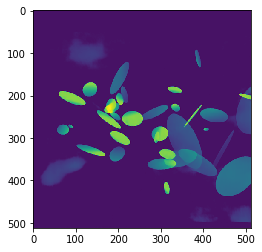

In [12]:
import matplotlib.pyplot as plt

plt.imshow(np.squeeze(imgs[0]))
plt.show()

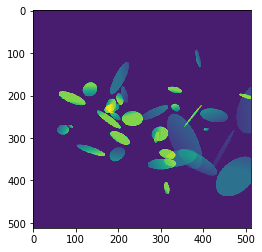

In [13]:
plt.imshow(np.squeeze(Y_val[0]))
plt.show()

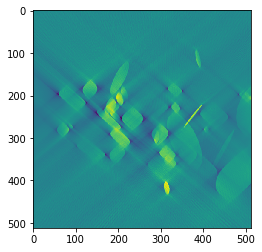

In [14]:
plt.imshow(np.squeeze(X_val[0]))
plt.show()

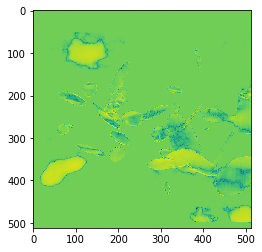

In [15]:
plt.imshow(np.log(np.squeeze((imgs[0]-Y_val[0])**2)))
plt.show()

In [15]:
#unet.save('unet_det.h5')

In [16]:
print(imgs.shape)
print(Y_val.shape)

(200, 512, 512, 1)
(200, 512, 512, 1)


In [32]:
def SNR(rec, oracle):
    sumP = np.sum(oracle)
    sumI = np.sum(rec)
    sumIP = np.sum(oracle*rec)
    sumI2 = np.sum(rec**2)
    A = np.array([[sumI2, sumI],[sumI, oracle.size]])
    b = np.array([[sumIP],[sumP]])
    c,_,_,_ = np.linalg.lstsq(A,b)
    #print(c)
    rec = c[0]*rec + c[1]
    err = np.sum((oracle - rec)**2)
    SNR = 10*np.log10(np.sum(oracle**2)/err)

    return SNR

def avg_SNR(REC, ORACLE):
    N = REC.shape[0]
    total_SNR = 0
    for i in range(N):
        total_SNR += SNR(REC[i], ORACLE[i])

    return total_SNR/N

In [33]:
print(avg_SNR(X_val, Y_val))

/home/oala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


4.721631451381818


In [34]:
print(avg_SNR(imgs, Y_val))

/home/oala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


18.50255179704286
